# Mtb metabolism

- Gene source: Rienksma et al. (2019) DOI: [10.3389/fcimb.2019.00144](https://doi.org/10.3389/fcimb.2019.00144)

Download Mtb model iEK1366 from its [publication](https://doi.org/10.1186/s12918-018-0557-y).

In [1]:
import requests
import zipfile
import io

response = requests.get("https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5834885/bin/12918_2018_557_MOESM3_ESM.zip", stream=True)
if response.status_code == 200:
    z = zipfile.ZipFile(io.BytesIO(response.content))
    z.extractall("iEK1011")

Read model

In [2]:
import cobra
import networkx as nx
import pandas as pd

from plotnet import NetPlotter

In [3]:
# model_invivo = cobra.io.load_json_model("iEK1011/iEK1011_inVivo_media.json")
# model_invivo.optimize()

In [4]:
model = cobra.io.load_json_model("iEK1011/iEK1011_m7H10_media.json")
model.summary()

In [5]:
np = NetPlotter(model)

# Bedaquiline

Inhibits essential cell-wall arabinan synthesis.

- Target is *atpE* ([Rv1305](https://mycobrowser.epfl.ch/genes/Rv1305)).

In [6]:
model.genes.Rv1305

<Gene Rv1305 at 0x217ede48820>

In [7]:
model.reactions.ATPS4r.gene_reaction_rule

'Rv1308 and Rv1304 and Rv1311 and Rv1310 and Rv1305 and Rv1306 and Rv1309 and Rv1307'

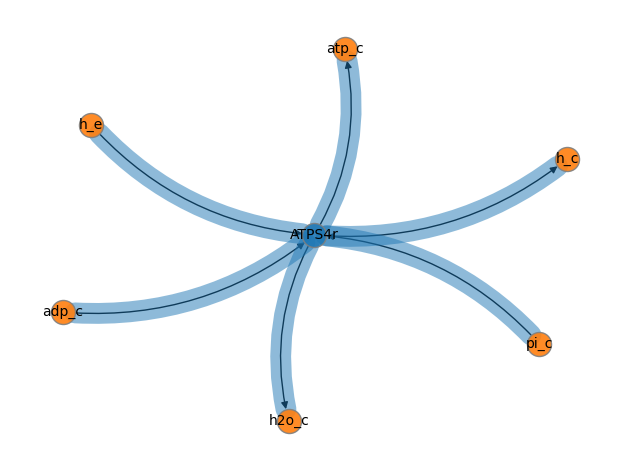

In [8]:
inhA_reactions = set(reaction.id for reaction in model.genes.Rv1305.reactions)
np.plot(reaction_ids=inhA_reactions)

In [9]:
std_growth = model.slim_optimize()
print(f"Standard growth: {std_growth:g}")

with model:
    model.genes.Rv1305.knock_out()
    growth = model.optimize().objective_value
    print(f"KO atpE: {growth:g} ({100 * (1 - growth / std_growth):.2f} % decrease)")

Standard growth: 0.0165647
KO atpE: 0.43 (-2495.88 % decrease)


C:\Users\Miguel\miniconda3\envs\misb\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


# Exercise: BTZ043

- Find function and target
- Draw the metabolic network around the target
- Simulate baseline growth
- Simulate the administration of BTZ043 by knocking its target out

In [10]:
# answer here!

# Isoniazid

Inhibits mycolic acid synthesis and folate synthesis.

- Activated by katG ([Rv1908c](https://mycobrowser.epfl.ch/genes/Rv1908c)).
- One of the targets is *inhA* ([Rv1484](https://mycobrowser.epfl.ch/genes/Rv1484)).

Timmins, G. S., & Deretic, V. (2006). Mechanisms of action of isoniazid. Molecular microbiology, 62(5), 1220–1227. https://doi.org/10.1111/j.1365-2958.2006.05467.x

- INH enters the mycobacterial cell by passive diffusion (Bardou et al., 1998).
- INH itself is not toxic to the bacterial cell, but acts as a prodrug and is activated by the mycobacterial enzyme KatG (Zhang et al., 1992), a multifunctional catalase-peroxidase that has other activities including peroxynitritase (Wengenack et al., 1999) and NADH oxidase (Singh et al., 2004).
- While the protective activities of KatG against host phagocyte NADPH oxidase-derived peroxides appear important in the absence of INH (Ng et al., 2004), strong selection for INH-resistant mutants occurs during treatment, with a major site for INH resistance mutations being the katG gene (Zhang et al., 1992; Heym et al., 1995; Slayden and Barry, 2000).
- In accord with its peroxidase activity, KatG activates INH by peroxidation to produce intracellular, INH-derived damaging species, and activation here refers to this formation of reactive INH-derived species.
- In the absence of NAD+ or NADP+, no significantly antimycobacterial INH-derived stable products are formed during in vitro activation.

In [11]:
katG = model.genes.Rv1908c
inhA = model.genes.Rv1484

In [12]:
katG

<Gene Rv1908c at 0x217ede48a60>

In [13]:
inhA

<Gene Rv1484 at 0x217ede4a080>

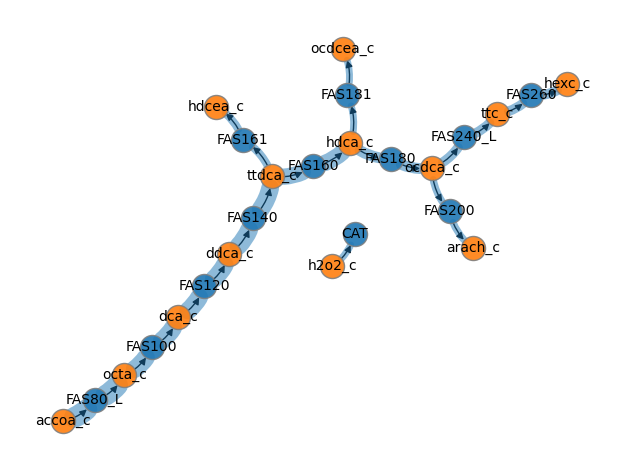

In [14]:
omit = {"h2o_c", "h_c", "nadph_c", "nadp_c", "nadh_c", "nad_c", "co2_c", "o2_c", "coa_c", "malcoa_c"}
reactions = set(reaction.id for reaction in katG.reactions) | set(reaction.id for reaction in inhA.reactions) 
np.plot(reaction_ids=reactions, omit_metabolites=omit)

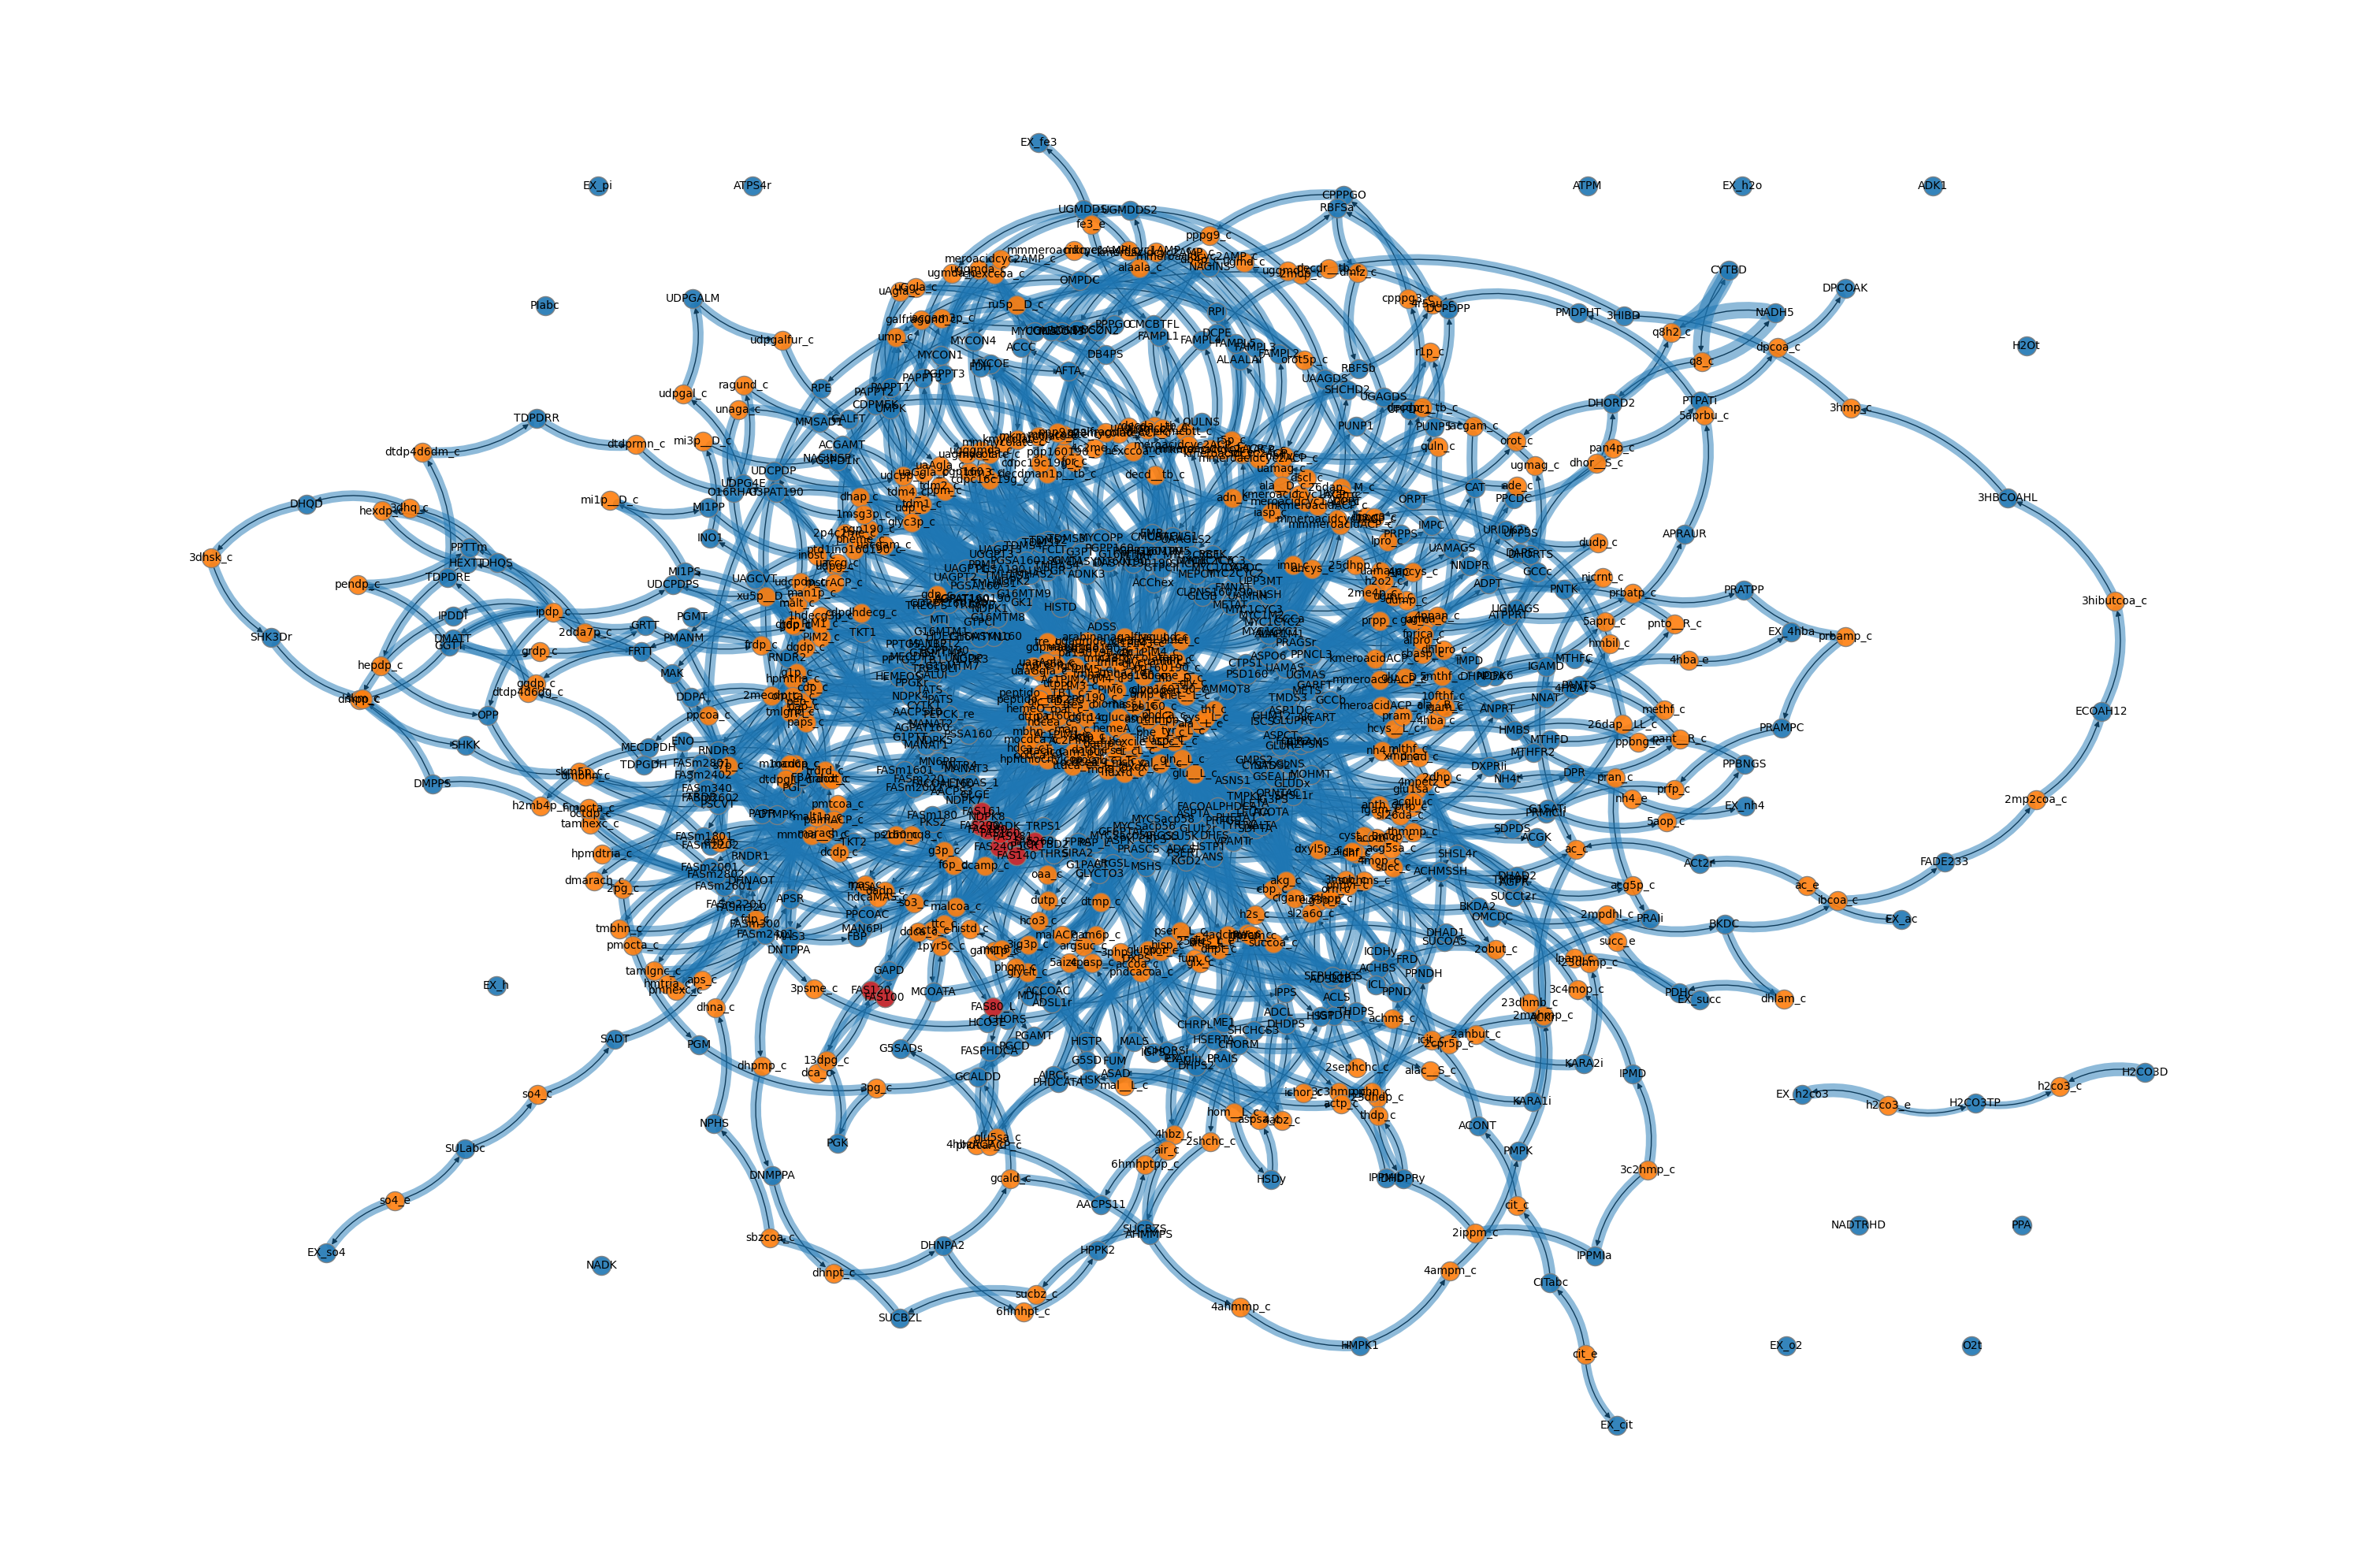

In [15]:
omit = {
    "h2o", "h", "atp", "adp", "amp", "pi",
    "coa", "nad", "co2", "ppi", "nad", "nadh", "nadp",
    "nadph", "fad", "fadh2", "o2", "ACP"
}

solution = model.optimize()
active_reactions = set(solution.fluxes[solution.fluxes.abs() > 1e-9].keys())  # 1e-9 == "zero"
inhA_reactions = set(reaction.id for reaction in inhA.reactions)

np.plot(
    reaction_ids=active_reactions,
    omit_metabolites=set(m + "_c" for m in omit) | set(m + "_e" for m in omit),
    highlight_nodes=inhA_reactions,
    figsize=(30, 20)
)

Test growth:

In [16]:
with model:
    solution = model.optimize()
    print(f"Baseline growth ({solution.status}) = {solution.objective_value:g}")
    baseline = solution.objective_value

Baseline growth (optimal) = 0.0165647


In [17]:
with model:
    inhA.knock_out()
    solution = model.optimize()
    reduction_percent = 100 * (baseline - solution.objective_value) / baseline
    print(f"Growth with inhA KO ({solution.status}) = {solution.objective_value:g} ({reduction_percent:.0f} % reduction)")

Growth with inhA KO (optimal) = 0 (100 % reduction)


In [18]:
with model:
    katG.knock_out()
    solution = model.optimize()
    reduction_percent = 100 * (baseline - solution.objective_value) / baseline
    print(f"Growth with katG KO ({solution.status}): {solution.objective_value:g} ({reduction_percent:.0f} % reduction)")

Growth with katG KO (optimal): 0.016563 (0 % reduction)


Compare baseline with *katG* KO (same objective, different distribution):

In [19]:
with model:  # this `with` statement is not necessary actually
    baseline_solution = model.optimize()

with model:
    katG.knock_out()
    katG_solution = model.optimize()

In [20]:
fluxes = pd.merge(
    baseline_solution.to_frame()["fluxes"], katG_solution.to_frame()["fluxes"],
    left_index=True, right_index=True,
    suffixes=("_baseline", "_katG")
)

fluxes["difference"] = fluxes.fluxes_katG - fluxes.fluxes_baseline
different = fluxes[fluxes.difference.abs() > 0.00001].sort_values("difference", ascending=False, key=lambda x: x.abs())

In [21]:
different

fluxes_baseline  fluxes_katG  difference
METSOXR1         0.000000     0.000477    0.000477
METOX1s          0.000000     0.000477    0.000477
TRDR             0.003137     0.003614    0.000477
CYTBD2           5.258224     5.257823   -0.000402
NADH10           5.258198     5.257796   -0.000402
NADTRHD          4.207754     4.207357   -0.000397
CAT              0.000239     0.000000   -0.000239
ATPS4r           4.167118     4.166913   -0.000205
O2t              2.633244     2.633282    0.000037
EX_o2           -2.633244    -2.633282   -0.000037
FPRA             3.636344     3.636381    0.000037
PTAr            -0.302387    -0.302356    0.000031
ACKr             0.302387     0.302356   -0.000031
ACt2r            0.300071     0.300041   -0.000030
EX_ac           -0.300071    -0.300041    0.000030
SUCOAS          -1.823136    -1.823154   -0.000018
KGD2            -1.824474    -1.824492   -0.000018
MALS             0.167600     0.167583   -0.000017
ICDHy            0.832426     0.832443    0.000017
ICL              0.167574     0.167557   -0.000017
H2CO3TP         -2.839110    -2.839126   -0.000016
H2CO3D           2.839110     2.839126    0.000016
EX_h2co3         2.839110     2.839126    0.000016
EX_h            -4.845535    -4.845551   -0.000016
MDH              0.134182     0.134168   -0.000014
HCO3E            0.122729     0.122716   -0.000012
NH4t            -0.886186    -0.886197   -0.000012
EX_nh4           0.886186     0.886197    0.000012
ACCOAC           0.111443     0.111431   -0.000011
NDPK1            0.111117     0.111106   -0.000011
PEPCK_re         0.107186     0.107175   -0.000011
PGM              0.102479     0.102469   -0.000010
ENO             -0.102479    -0.102469    0.000010

Baseline:


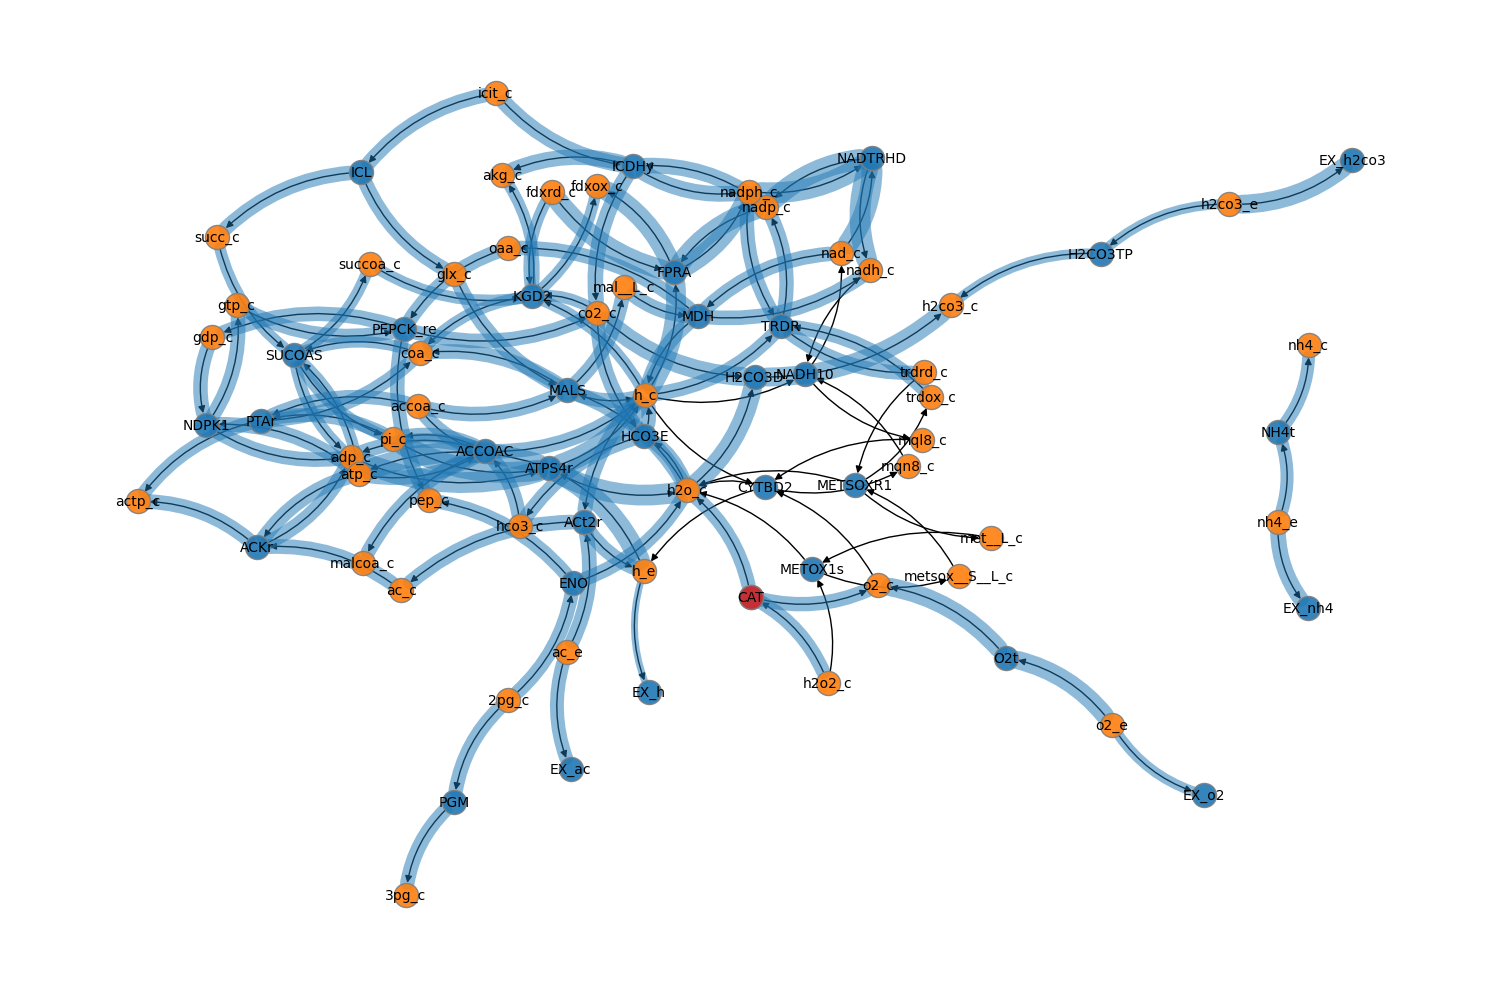

katG KO:


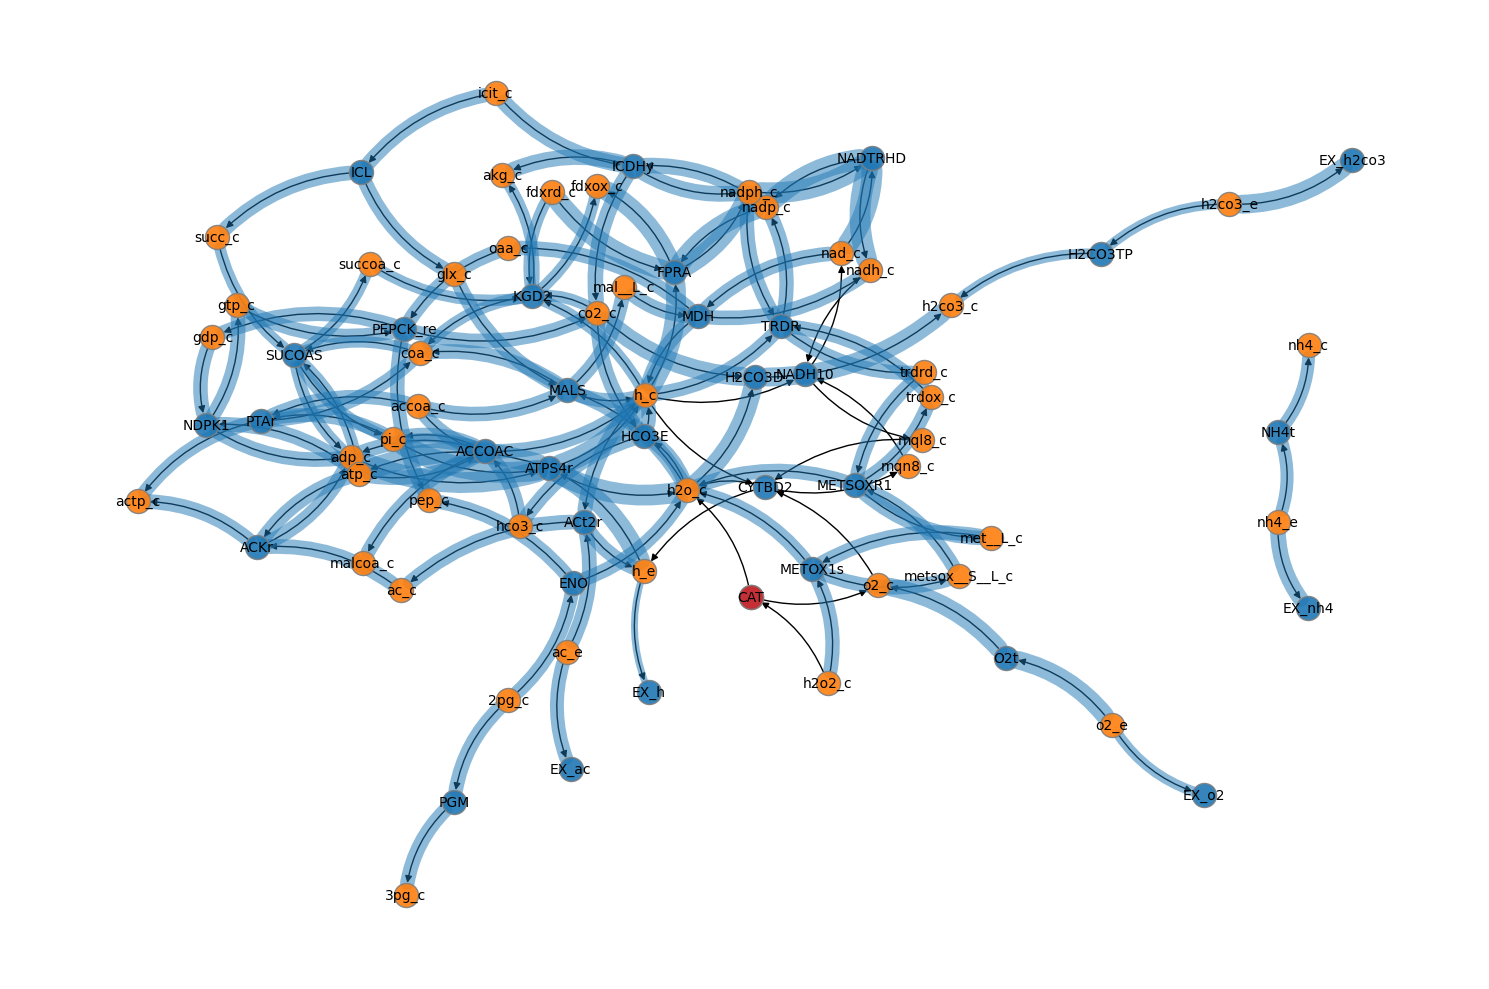

In [22]:
omit = set()

print("Baseline:")
np.plot(
    reaction_ids=set(different.index),
    omit_metabolites=omit,
    highlight_nodes={"CAT"},
    figsize=(15, 10)
)

print("katG KO:")
with model:
    katG.knock_out()
    np.plot(
        reaction_ids=set(different.index),
        omit_metabolites=omit,
        highlight_nodes={"CAT"},
        figsize=(15, 10)
    )

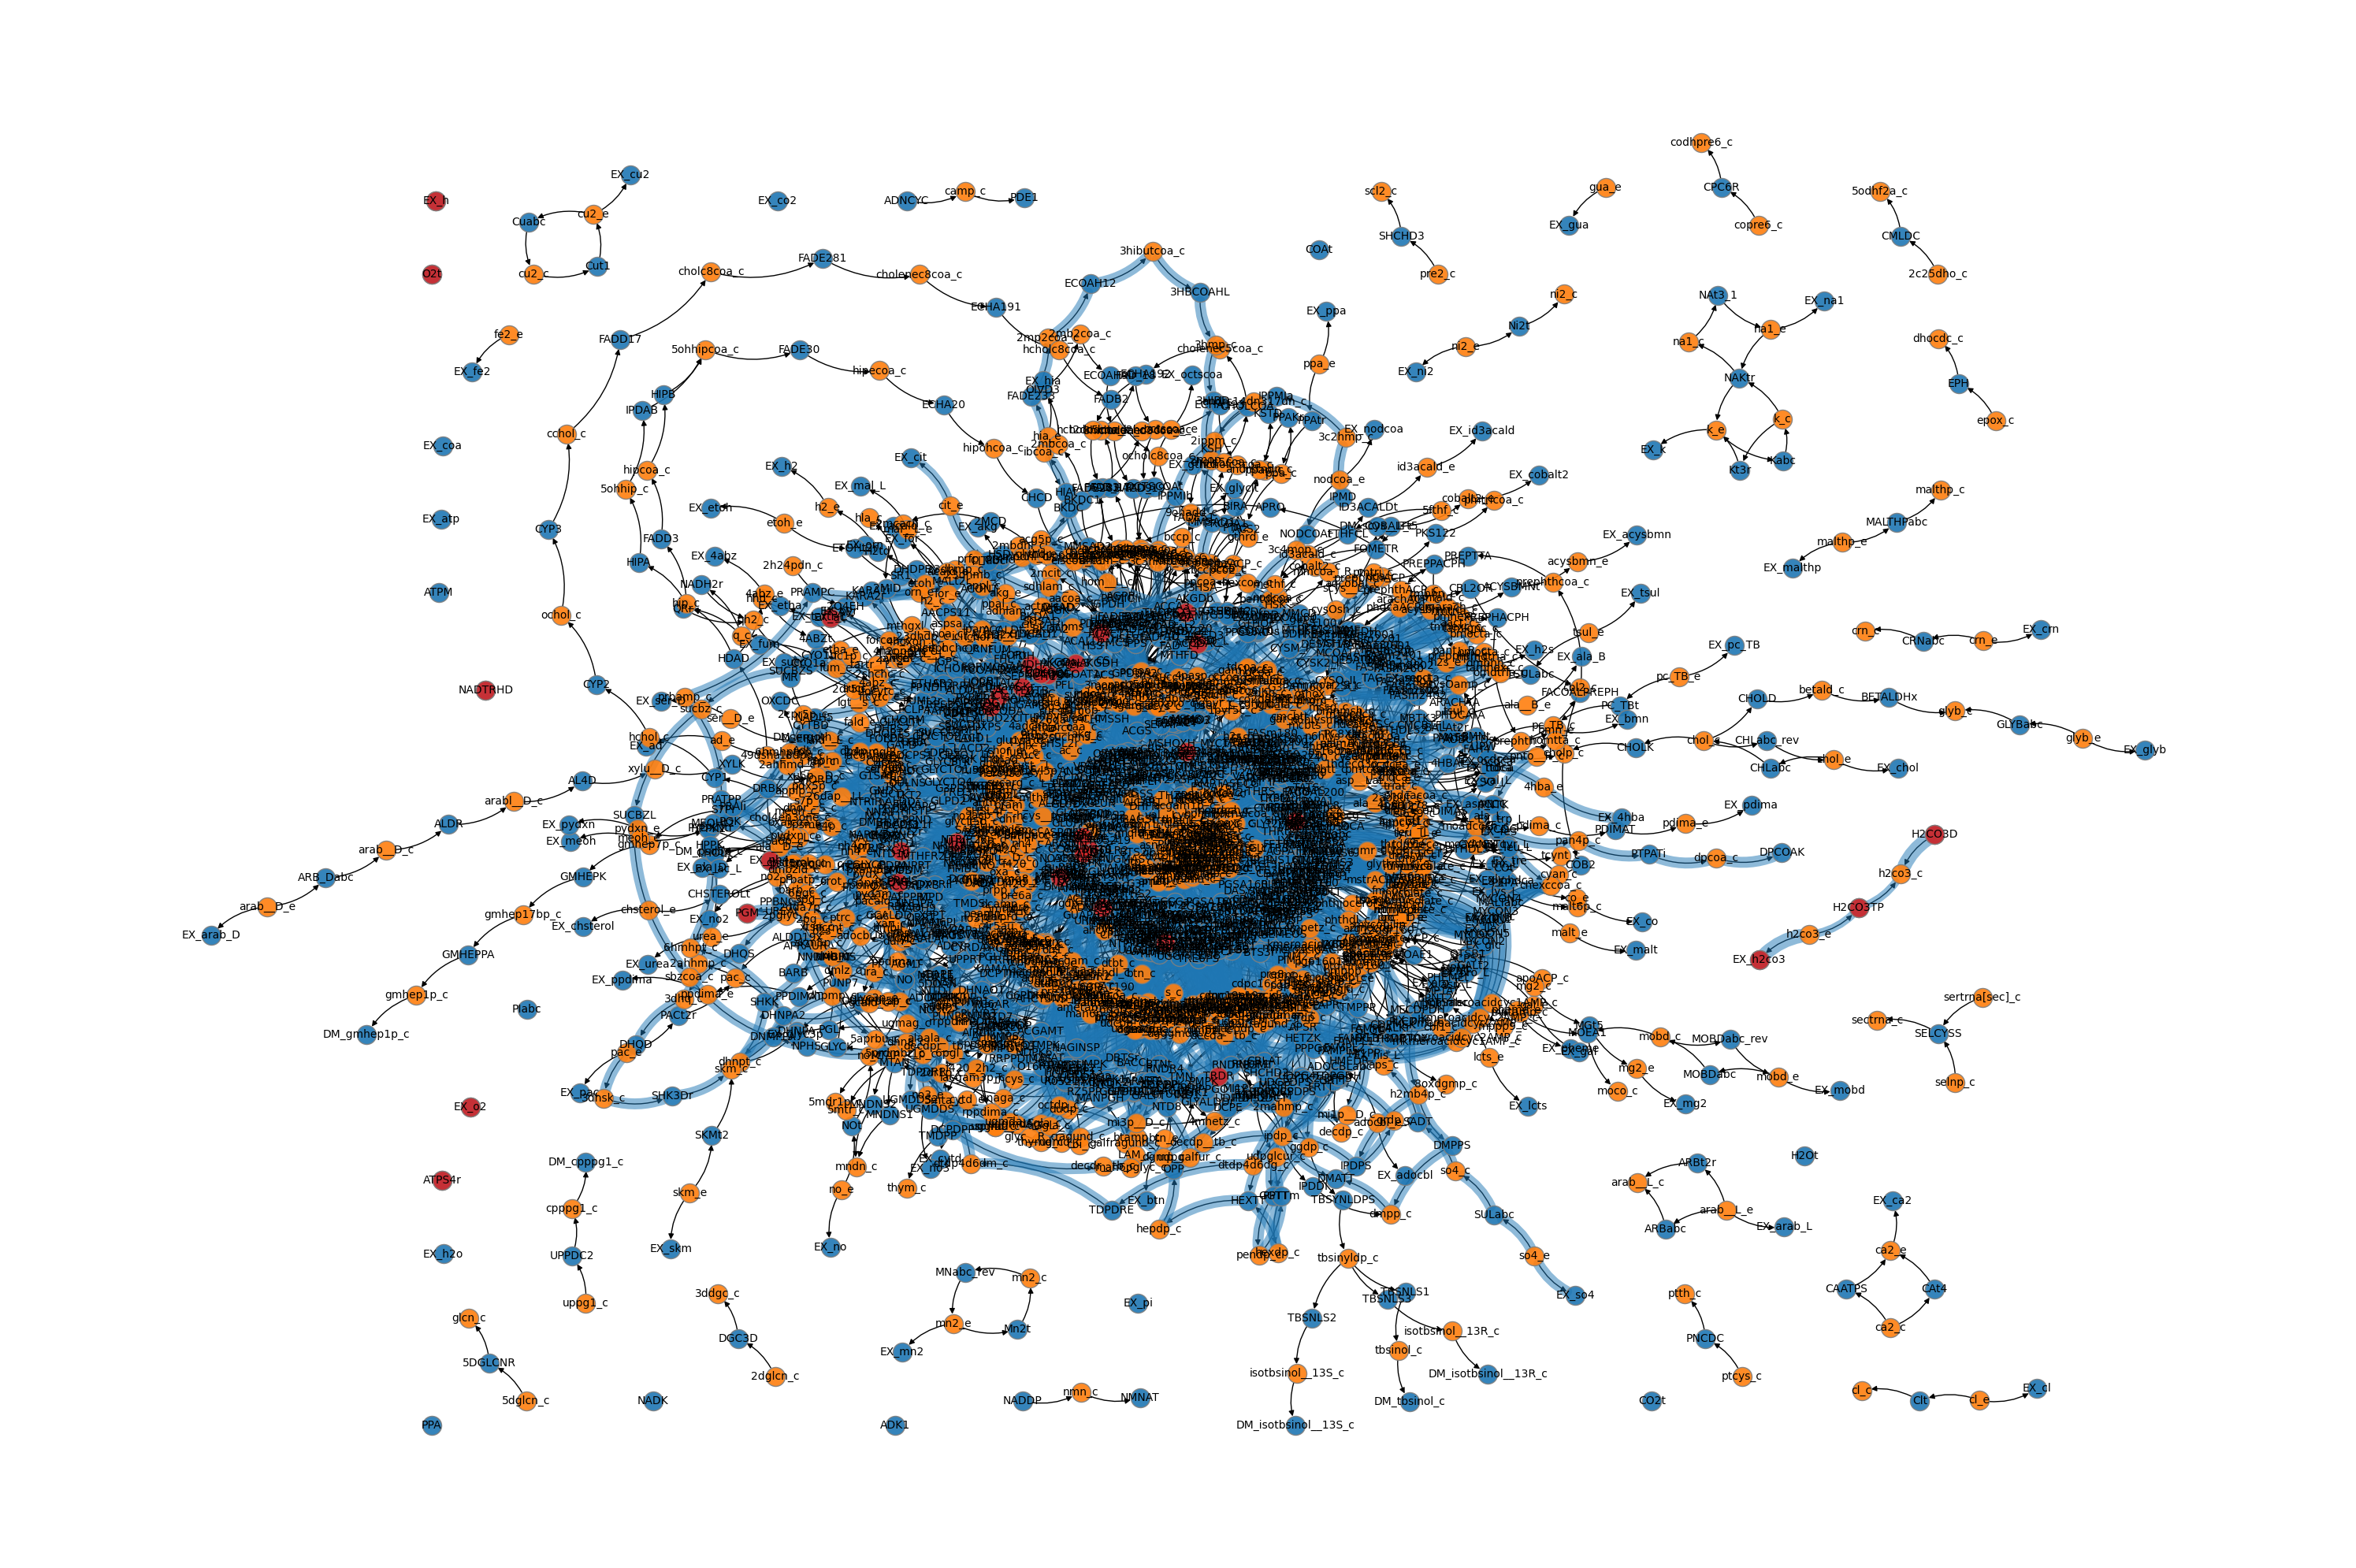

In [23]:
omit = {
    "h2o", "h", "atp", "adp", "amp", "pi",
    "coa", "nad", "co2", "ppi", "nad", "nadh", "nadp",
    "nadph", "fad", "fadh2", "o2", "ACP"
}

active_reactions = set(katG_solution.fluxes[katG_solution.fluxes.abs() > 1e-9].keys())

np.plot(
    reaction_ids=[reaction.id for reaction in model.reactions],
    omit_metabolites=set(m + "_c" for m in omit) | set(m + "_e" for m in omit),
    highlight_nodes=set(different.index),
    figsize=(30, 20)
)